# Data-based models for NMPC

Implementation of the robust multi-stage NMPC algorithm using do-mpc. The simulator uses the "true" physical MSMPR model. For the controller model, two different data-based model functions are defined for the standard NN and NN with BLL.

In [3]:
import numpy as np
import casadi as ca
import do_mpc
import matplotlib.pyplot as plt
import pickle
import sys
import os
import time

import databasedmodel
import simulator
import mpc

sys.path.append('./../Data generation')
import model
import functions_MSMPR

sys.path.append('./../System identification/BLL')
sys.path.append('./../System identification')
import tools
import functions

Load data-based models

In [5]:
fileo = open('./../System identification/model_bll_500.pkl', 'rb')
BLL_layer1_w0 = pickle.load(fileo)
BLL_layer1_w1 = pickle.load(fileo)
BLL_layer2_w0 = pickle.load(fileo)
BLL_layer2_w1 = pickle.load(fileo)
BLL_layer3_w0 = pickle.load(fileo)
BLL_layer3_w1 = pickle.load(fileo)
BLL_Sigma_p_bar = pickle.load(fileo)
BLL_log_sigma_e = pickle.load(fileo)
BLL_scaler_NN_x_scale = pickle.load(fileo)
BLL_scaler_NN_x_mean = pickle.load(fileo)
BLL_scaler_NN_y_scale = pickle.load(fileo)
BLL_scaler_NN_y_mean = pickle.load(fileo)
BLL_scaler_BLL_x_scale = pickle.load(fileo)
BLL_scaler_BLL_x_mean = pickle.load(fileo)
BLL_scaler_BLL_y_scale = pickle.load(fileo)
BLL_scaler_BLL_y_mean = pickle.load(fileo)
fileo.close()

fileo = open('./../System identification/model_NN_500.pkl', 'rb')
NN_layer1_w0 = pickle.load(fileo)
NN_layer1_w1 = pickle.load(fileo)
NN_layer2_w0 = pickle.load(fileo)
NN_layer2_w1 = pickle.load(fileo)
NN_layer3_w0 = pickle.load(fileo)
NN_layer3_w1 = pickle.load(fileo)
NN_scaler_NN_x_scale = pickle.load(fileo)
NN_scaler_NN_x_mean = pickle.load(fileo)
NN_scaler_NN_y_scale = pickle.load(fileo)
NN_scaler_NN_y_mean = pickle.load(fileo)
fileo.close()

In [9]:
fileo = open('./../System identification/model_bll_500.pkl', 'rb')
model_BLL = pickle.load(fileo)
Sigma_p_bar = pickle.load(fileo)
log_sigma_e = pickle.load(fileo)
scaler_BLL = pickle.load(fileo)
scaler_NN = pickle.load(fileo)
fileo.close()

fileo = open('./../System identification/model_NN_500.pkl', 'rb')
model_NN = pickle.load(fileo)
scaler_NN = pickle.load(fileo)
fileo.close()

In [7]:
import importlib

In [47]:
importlib.reload(databasedmodel)
importlib.reload(mpc)
importlib.reload(simulator)
importlib.reload(functions_MSMPR)
importlib.reload(model)
importlib.reload(functions)

<module 'functions' from 'c:\\Users\\smcojohn\\Documents\\GitHub\\multistageNMPC_BLL\\NMPC\\./../System identification\\functions.py'>

In [53]:

# Use NN with BLL or standard NN
# ONNX transformation of models not yet implemented
BLL = False
if BLL:
    BLL_sigma_e2 = np.exp(2*BLL_log_sigma_e)
    param_databased = BLL_layer1_w0, BLL_layer1_w1, BLL_layer2_w0, BLL_layer2_w1, BLL_layer3_w0, BLL_layer3_w1, BLL_scaler_NN_x_scale, BLL_scaler_NN_x_mean, BLL_scaler_NN_y_scale, BLL_scaler_NN_y_mean, BLL_scaler_BLL_x_scale, BLL_scaler_BLL_x_mean, BLL_scaler_BLL_y_scale, BLL_scaler_BLL_y_mean, BLL_Sigma_p_bar, BLL_sigma_e2
    model_databased = databasedmodel.model_MSMPR_BLL(param_databased)
else:
    param_databased = NN_layer1_w0, NN_layer1_w1, NN_layer2_w0, NN_layer2_w1, NN_layer3_w0, NN_layer3_w1, NN_scaler_NN_x_scale, NN_scaler_NN_x_mean, NN_scaler_NN_y_scale, NN_scaler_NN_y_mean
    model_databased = databasedmodel.model_MSMPR_NN(param_databased)

# Define parameters:
w_seed = 0.02
rho_cryst = 1432 # Density of crystals
rho = 1043 # Density in crystallizer
V = 10 # Volume of crystallizer
kv = np.pi/6
T_feed0 = 350
c_feed0 = functions_MSMPR.solubility(T_feed0)


# Define inital moments (based on exponential distribution)
mu_initial = np.array([1.02921849e+08, 4.11772806e+04, 1.75005454e+01])

cryst_param = mu_initial

T_feed0 = 350
c_feed0 = functions_MSMPR.solubility(T_feed0)
param_MSMPR = {'rho_cryst':rho_cryst,'V':V,'rho':rho, 'T_feed':T_feed0, 'c_feed':c_feed0}

model_MSMPR = model.model_MSMPR(cryst_param, param_MSMPR)

simulator_MSMPR = simulator.simulator(model_MSMPR)
mpc_MSMPR = mpc.mpc_MSMPR_data_based(model_databased, BLL) # data-based model

# Set inital guess for MPC
mpc_MSMPR.set_initial_guess()

# Set initial guess for simulator to avoid numerical errors
for i in range(mpc_MSMPR.settings.n_horizon+1):
    for b in range(mpc_MSMPR.n_combinations):
        mpc_MSMPR.opt_x_num['_x',i,b] = ca.DM([350, 320, 0.23, 4e-4, 1e0, 1e-3, 1e-6])
        if i<mpc_MSMPR.settings.n_horizon:
            mpc_MSMPR.opt_x_num['_u',i,b] = ca.DM([350, 1.0, 0.1])

x0 = simulator_MSMPR.x0
u0 = simulator_MSMPR.u0

x0['T'] = T_feed0
x0['T_j'] = T_feed0
x0['c'] = c_feed0+1e-5 # Small value added to avoid numerical error
x0['mu'] = mu_initial

u0['T_j_in'] = 300
u0['F_j'] = 0.3
u0['F_feed'] = 0.2


t_sim = 50
x_next = x0.cat

time1 = time.perf_counter()

for t in range(t_sim):
    print(t)
    # Data based model
    mpc_x = functions.MPC_input(x_next) 
    u0 = mpc_MSMPR.make_step(mpc_x)


    # Simulate physical model
    x_next = simulator_MSMPR.make_step(u0)

time2 = time.perf_counter()

print(time2-time1)
do_mpc.data.save_results([mpc_MSMPR, simulator_MSMPR], 'MSMPR')

0
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      777
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      578

Total number of variables............................:      107
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       66
                     variables with only upper bounds:        0
Total number of equality constraints.................:       77
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -9.0030596e+08 5.31e+04 2.50e+03  -1.0 0.00e+00    -  0.00e+00 0.00e+0

Succesfull steps: 50 / 50


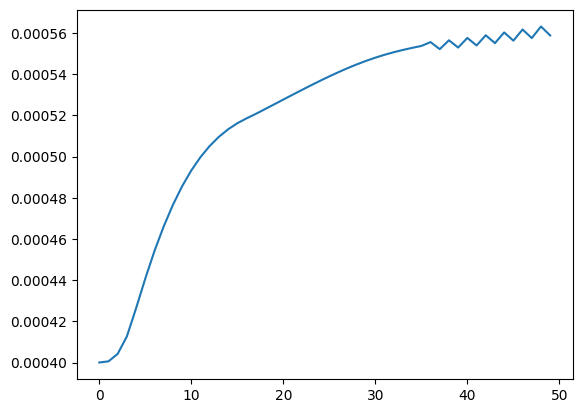

In [54]:
results = do_mpc.data.load_results('./results/001_MSMPR.pkl')
mpc_MSMPR = results['mpc']
print('Succesfull steps:', np.count_nonzero(mpc_MSMPR.success), '/', len(mpc_MSMPR.success))
x = results['simulator']['_aux','L10']

plt.plot(x)